In [1]:
from fuzzywuzzy import fuzz

import os
import sys

import pandas as pd
pd.options.display.max_columns = 999
import sqlalchemy as sqla
from sqlalchemy import create_engine
%matplotlib inline  

DB_URI = os.getenv('CD_DWH')
engine = create_engine(DB_URI)

In [2]:
QUERY = """
select
    regexp_replace(lower(recipient_candidate_name), '[^a-z ]', '', 'g') as clean_name,
    count(recipient_candidate_name),
    recipient_candidate_name
from trg_analytics.candidate_contributions
group by recipient_candidate_name
"""
with engine.begin() as conn:
    sql_results = pd.read_sql(QUERY, conn)
    
print("Size:", sql_results.size)
sql_results.head(10)


Size: 4692


,clean_name,count,recipient_candidate_name
0,None,0,None
1,mc hugh peter a,33,"MC HUGH, PETER A."
2,ali anila,163,"ALI, ANILA"
3,knight william j pete,195,"KNIGHT, WILLIAM J. \PETE\"""""
4,hill jerry a,5404,"HILL, JERRY A."
5,harris elihu,22,"HARRIS, ELIHU"
6,acosta georgia l,26,"ACOSTA, GEORGIA L."
7,guillen abel,1300,"GUILLEN, ABEL"
8,gerber donna c,1026,"GERBER, DONNA C."
9,mc iver barbara g,259,"MC IVER, BARBARA G."


In [3]:
results = sql_results.drop(0)
results.index = range(len(results))
# results = sql_results[1:] # ignore None
# results.reset_index(drop=True)

results.head(10)

,clean_name,count,recipient_candidate_name
0,mc hugh peter a,33,"MC HUGH, PETER A."
1,ali anila,163,"ALI, ANILA"
2,knight william j pete,195,"KNIGHT, WILLIAM J. \PETE\"""""
3,hill jerry a,5404,"HILL, JERRY A."
4,harris elihu,22,"HARRIS, ELIHU"
5,acosta georgia l,26,"ACOSTA, GEORGIA L."
6,guillen abel,1300,"GUILLEN, ABEL"
7,gerber donna c,1026,"GERBER, DONNA C."
8,mc iver barbara g,259,"MC IVER, BARBARA G."
9,stoker mike,1574,"STOKER, MIKE"


In [28]:
from fuzzywuzzy import fuzz

size = len(results["clean_name"])

for i in range(size):
    name = results["clean_name"][i]
    for j in range(i + 1, size):
        test = results["clean_name"][j]
        fuz = fuzz.ratio(name, test)
        if fuz >= 77: # need to find how low this can go
            print("{}% Similar: {:^25}  {:^25} {:>5} {:>5}".format(fuz, name, test, results["count"][i], results["count"][j]))

94% Similar:     mc iver barbara g           mc iver barbara        259     1
93% Similar:      runner george c             runner george        2816    63
83% Similar:        hill steve               phillips steve          28   416
92% Similar:        hanson mark               hanson mark n           5    57
91% Similar:       dutra john a                dutra john          2238    17
93% Similar:       yamada mariko             yamada mariko m        292  2171
78% Similar:        adams steve               davis steven          212    14
78% Similar:    dominguez francisco         ramirez francisco       121     1
92% Similar:       gardner dean              gardner m dean          36   732
92% Similar:       price curren              price curren d        1017  1583
87% Similar:       akili gregory               akili greg           118     4
90% Similar:  mcdonald kristine lang      mc donald kristine l        9    26
91% Similar:        king david                king david a      

86% Similar:         leyes mak                leyes mark a          130   252
92% Similar:        medina jose               medina jose j          59  1740
92% Similar:        gaines beth               gaines beth b         111  1214
94% Similar:     schaupp charles e           schaupp charles        149     4
90% Similar:         cook paul                 cook paul j           30  1618
93% Similar:       ortiz deborah             ortiz deborah v          1  1537
81% Similar:   johannessen k maurice        johannessen mark        420   178
83% Similar:       jenkins stew             jenkins stewart d         6   199
78% Similar:  dickerson richard dick         dickerson dick         842     1
93% Similar:       hodges sherry             hodges sherry m          9  1096
87% Similar:       gaines edward            gaines edward ted       200   954
93% Similar:       gaines edward             gaines edward t        200  3503
78% Similar:       gaines edward               gaines ted       

95% Similar:   antonovich michael d        antonovich michael      1406     5
78% Similar:       mullin kevin                mullin gene         2093   994
93% Similar:      mc carthy kevin             mccarty kevin        3417   212
78% Similar:       leonard bill                conrad bill          755   112
85% Similar:      polanco richard              pan richard           59  4566
93% Similar:     keating janice e            keating janice         161    62
88% Similar:        roesch jean              roesch jean dr          12    58
95% Similar:    von szeliski heidi        von szeliski heidi j        3   340
82% Similar:        rao robert                frost robert          235    50
88% Similar:     gutierrez richard           aguirre richard          5    14
91% Similar:    mc fadden bradley j         mcfadden bradley         24     1
92% Similar:      marquez luis h              marquez luis          392    31
90% Similar:      ebenstein jeff            ebenstein jeffery   

In [29]:
# Noticing things like:
# 80% Similar:       blount steve               blanton steve          14     6 are these 4
# 78% Similar:       blount steve                young steve           14    20 different people?
# 78% Similar:       davis michael               davis mike           322  1559 
# 80% Similar:        diep tyler                 izen tyler           151    39 80%, possibly different people
# 80% Similar:     harrison michael            wilson michael         315    39 
# 88% Similar:     harrison michael          harrington michael       315     3 80% for 4 people
# 85% Similar:    camejo peter miguel          camejo peter m         472     2 85% for a probably match
# 78% Similar:    dominguez francisco         ramirez francisco       121     1 
# 79% Similar:      cohelan timothy        cohelan timothy douglas     26   145 79% same person?

In [214]:
# data.sort(key=lambda tup: tup[1])  # sorts in place
from fuzzywuzzy import fuzz

size = len(results["clean_name"])
orgi_name = results["recipient_candidate_name"]

print("Fuzzy comparing")

# Above cell but compressed with original name and stored to a variable -- I wanted to try it with list comprehension... 
data = [[results["clean_name"][i], [[fuzz.ratio(results["clean_name"][i], results["clean_name"][j]), results["clean_name"][j], results["recipient_candidate_name"][j], results["count"][j]] for j in range(i + 1 , size)], results["recipient_candidate_name"][i], results["count"][i]] for i in range(size)]

# ignore None 
if data[0][0] is None:
    data = data[1:]


Fuzzy comparing


In [215]:
print("Sorting comparisons")
# Need to ignore the last few because their comparisons are 0
for dat in data[:-2]:
    # print(dat[1][1][0])
    # break
    dat[1].sort(reverse=True, key=lambda t: t[0])
    
              


Sorting comparisons


In [216]:
# Taking a peak at the 3rd element from the back
print(data[-3])
# Because we (should be) only comparing unique rows the last few have smaller and more viewable 'comparison array'

['maze bill', [[29, 'harrington michael mickey', 'HARRINGTON, MICHAEL \\MICKEY\\""', 44], [11, 'scott jack', 'SCOTT, JACK', 671]], 'MAZE, BILL', 1536]


In [259]:
print("Everyone with at least 96 % match in this dataset")
print("Match% name (count) 'name_in_db' -- 'name_in_db (count)")

print()
for dat in data:
    for d in dat[1]:
        # print(d[1])
        if d[0] < 96:
            break
        else:
            print("{:>3}% {:>20}: ({}) {:^25} -- {:^25} ({})".format(d[0], dat[0], dat[3], dat[2], d[2], d[3]))

Everyone with at least 96 % match in this dataset
Match% name (count) 'name_in_db' -- 'name_in_db (count)

 96%         mc cann john: (616)       MC CANN, JOHN       --       MCCANN, JOHN        (6)
100%    dickson kenneth c: (2)    DICKSON, KENNETH C     --    DICKSON, KENNETH C.    (69)
 97%     de saulnier mark: (2517)     DE SAULNIER, MARK     --     DESAULNIER, MARK      (658)
100%        vargas juan c: (8)      VARGAS, JUAN C       --      VARGAS, JUAN C.      (2845)
 96%        papan virgina: (1)      PAPAN, VIRGINA       --      PAPAN, VIRGINIA      (8)
 96%         yee  betty t: (5048)      YEE , BETTY T.       --       YEE, BETTY T.       (351)
100%          baca jr joe: (12)      BACA. JR., JOE       --       BACA JR., JOE       (2013)
 96%       garamendi john: (9487)      GARAMENDI, JOHN      --      GARAMEDI, JOHN       (234)
 97%       mcgarry nellie: (9)      MCGARRY, NELLIE      --     MC GARRY, NELLIE      (626)
 97%      quintero andres: (99)     QUINTERO, ANDRES    

In [218]:
print(data[-5][0]) ## Clean name
print(data[-5][2]) ## 'original' name in the db
print(data[-5][3]) ## that name's count
print(data[-5][1]) ## Comparisons against all the other people that haven't already compared themselves to this person
print(data[-5][1][-1]) ## the last comparison for this person [fuzzy%, clean_name, original_name, count]

renison john
RENISON, JOHN
93
[[36, 'scott jack', 'SCOTT, JACK', 671], [32, 'harrington michael mickey', 'HARRINGTON, MICHAEL \\MICKEY\\""', 44], [25, 'wayne howard', 'WAYNE, HOWARD', 475], [19, 'maze bill', 'MAZE, BILL', 1536]]
[19, 'maze bill', 'MAZE, BILL', 1536]


In [6]:
#print(data[0])

In [36]:
# data.sort(key=lambda tup: tup[1])  # sorts in place
from fuzzywuzzy import fuzz

size = len(results["clean_name"])
orgi_name = results["recipient_candidate_name"]

mock_next_key = 1
mock_db = {}

print("Fuzzy comparing")

# Above cell but compressed with original name and stored to a variable -- I wanted to try it with list comprehension... 
data = [[results["clean_name"][i], [[fuzz.ratio(results["clean_name"][i], results["clean_name"][j]), results["clean_name"][j], results["recipient_candidate_name"][j], results["count"][j]] for j in range(size) if i != j], results["recipient_candidate_name"][i], results["count"][i]] for i in range(size)]

# ignore None 
#if data[0][0] is None:
#    data = data[1:]

    
## Changed it to compare everything vs everything


Fuzzy comparing
Sorting comparisons
Everyone with less than 56% match in this dataset
Match% name (count) 'name_in_db' -- 'name_in_db (count)



TypeError: '<' not supported between instances of 'list' and 'int'

In [45]:
data[0][1][0][0]

64

In [46]:
print("Sorting comparisons")
# Need to ignore the last few because their comparisons are 0
for dat in data:
    # print(dat[1][1][0])
    # break
    dat[1].sort(reverse=True, key=lambda t: t[0])
    
data.sort(reverse=True, key=lambda t: t[1][0][0])
    


Sorting comparisons


In [56]:
count = 0

print("Match% name (count) 'name_in_db' -- 'name_in_db (count)")
for dat in data:
    d = dat[1][0]
    if d[0] > 65:
        count += 1
        print("{:>3}%   ({}) {:>25}    {:<25} ({})".format(d[0], dat[3], dat[2], d[2], d[3]))
print()
print()
print(count)
print(count/size)

Match% name (count) 'name_in_db' -- 'name_in_db (count)
100%   (2)        DICKSON, KENNETH C    DICKSON, KENNETH C.       (69)
100%   (8)            VARGAS, JUAN C    VARGAS, JUAN C.           (2845)
100%   (69)       DICKSON, KENNETH C.    DICKSON, KENNETH C        (2)
100%   (12)            BACA. JR., JOE    BACA JR., JOE             (2013)
100%   (2845)           VARGAS, JUAN C.    VARGAS, JUAN C            (8)
100%   (2013)             BACA JR., JOE    BACA. JR., JOE            (12)
100%   (40)          JONES, JUDITH E.    JONES, JUDITH E           (15)
100%   (3)         JEFFRIES, KEVIN D    JEFFRIES, KEVIN D.        (1203)
100%   (1203)        JEFFRIES, KEVIN D.    JEFFRIES, KEVIN D         (3)
100%   (15)           JONES, JUDITH E    JONES, JUDITH E.          (40)
 97%   (2517)         DE SAULNIER, MARK    DESAULNIER, MARK          (658)
 97%   (9)           MCGARRY, NELLIE    MC GARRY, NELLIE          (626)
 97%   (99)          QUINTERO, ANDRES    QUINTERO, ANDRE           (87)

In [60]:
# Look into the other thing fuzzy can do, might produce higher results


In [70]:
t_r = sql_results.drop(0)
t_r.index = range(len(t_r))
head(t_r)


NameError: name 'head' is not defined

In [52]:

#t_r["highest_fuzzy_match_number"], t_r["highest_fuzzy_match_name"] = [  for i in size(t_r)]

t_r["highest_fuzzy_match_number"] = -1
t_r["highest_fuzzy_match_name"] = -1
t_r["highest_fuzzy_match_count"] = -1

size = len(t_r["clean_name"])

for i in range(size):
    name = t_r["clean_name"][i]
    r = []
    
    r += [[ 0, "self", 0]]
    
    for j in range(i + 1, size):
        test = t_r["clean_name"][j]
        fuz = fuzz.ratio(name, test)
        r += [[ fuz, t_r["recipient_candidate_name"][j], t_r["count"][j] ]]
    
    #print(r)
    #break
    r.sort(reverse=True, key=lambda x: x[0])
    t_r.loc[i, "highest_fuzzy_match_number"] = r[0][0]
    t_r.loc[i, "highest_fuzzy_match_name"] = r[0][1]
    t_r.loc[i, "highest_fuzzy_match_count"] = r[0][2]



In [53]:
n_r = t_r.sort_values("highest_fuzzy_match_number", ascending=False)
n_r

,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
1099,jones judith e,40,"JONES, JUDITH E.",100,"JONES, JUDITH E",15
602,baca jr joe,12,"BACA. JR., JOE",100,"BACA JR., JOE",2013
418,vargas juan c,8,"VARGAS, JUAN C",100,"VARGAS, JUAN C.",2845
1171,jeffries kevin d,3,"JEFFRIES, KEVIN D",100,"JEFFRIES, KEVIN D.",1203
212,dickson kenneth c,2,"DICKSON, KENNETH C",100,"DICKSON, KENNETH C.",69
765,mc carty kevin,1849,"MC CARTY, KEVIN",97,"MC CARTHY, KEVIN",3417
734,quintero andres,99,"QUINTERO, ANDRES",97,"QUINTERO, ANDRE",87
342,de saulnier mark,2517,"DE SAULNIER, MARK",97,"DESAULNIER, MARK",658
726,mcgarry nellie,9,"MCGARRY, NELLIE",97,"MC GARRY, NELLIE",626
689,garamendi john,9487,"GARAMENDI, JOHN",96,"GARAMEDI, JOHN",234


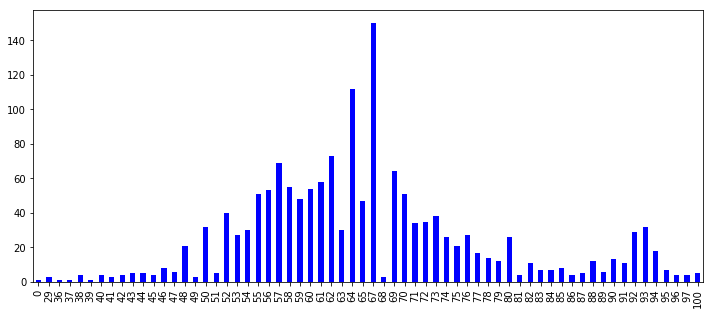

In [54]:
n_r["highest_fuzzy_match_number"].value_counts(sort=False).plot(kind="bar", figsize=(12,5), colormap="winter")

In [55]:
d = n_r[n_r["highest_fuzzy_match_number"] > 90]
print(len(d))
display(d)

110


,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
1099,jones judith e,40,"JONES, JUDITH E.",100,"JONES, JUDITH E",15
602,baca jr joe,12,"BACA. JR., JOE",100,"BACA JR., JOE",2013
418,vargas juan c,8,"VARGAS, JUAN C",100,"VARGAS, JUAN C.",2845
1171,jeffries kevin d,3,"JEFFRIES, KEVIN D",100,"JEFFRIES, KEVIN D.",1203
212,dickson kenneth c,2,"DICKSON, KENNETH C",100,"DICKSON, KENNETH C.",69
765,mc carty kevin,1849,"MC CARTY, KEVIN",97,"MC CARTHY, KEVIN",3417
734,quintero andres,99,"QUINTERO, ANDRES",97,"QUINTERO, ANDRE",87
342,de saulnier mark,2517,"DE SAULNIER, MARK",97,"DESAULNIER, MARK",658
726,mcgarry nellie,9,"MCGARRY, NELLIE",97,"MC GARRY, NELLIE",626
689,garamendi john,9487,"GARAMENDI, JOHN",96,"GARAMEDI, JOHN",234


In [56]:
display(n_r[(n_r["highest_fuzzy_match_number"] < 90) & (80 <= n_r["highest_fuzzy_match_number"])])

,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
251,hallinan jr tom,18,"HALLINAN JR., TOM",89,"HALLINAN, TOM",3
171,fong paul,2124,"FONG, PAUL",89,"SONG, PAUL",9
310,hallinan tom,3,"HALLINAN, TOM",89,"HALLINAN, THOMAS",383
505,galvan isaac,1,"GALVAN, ISAAC",89,"GALVAN , ISAAC J.",125
816,kiraly virginia c,25,"KIRALY, VIRGINIA C.",89,"KIRALY, VIRGINIA CHANG",2
465,monville iii louis g,321,"MONVILLE III, LOUIS G.",89,"MONVILLE III, LOU",10
532,martinez diane j,98,"MARTINEZ , DIANE J.",88,"MARTINEZ, DIANE",2
1252,miles jr lawrence w,206,"MILES JR., LAWRENCE W.",88,"MILES , LAWRENCE",1
917,roesch jean,12,"ROESCH, JEAN",88,"ROESCH, JEAN DR.",58
857,pacheco robert bob,876,"PACHECO, ROBERT \BOB\""""",88,"PACHECO, ROBERT",17


In [57]:
t_r["highest_fuzzy_match_number"] = -1
t_r["highest_fuzzy_match_name"] = -1
t_r["highest_fuzzy_match_count"] = -1

size = len(t_r["clean_name"])

for i in range(size):
    name = t_r["clean_name"][i]
    r = []
    
    r += [[ 0, "self", 0]]
    
    for j in range(i + 1, size):
        test = t_r["clean_name"][j]
        fuz = fuzz.partial_ratio(name, test)
        r += [[ fuz, t_r["recipient_candidate_name"][j], t_r["count"][j] ]]
    
    #print(r)
    #break
    r.sort(reverse=True, key=lambda x: x[0])
    t_r.loc[i, "highest_fuzzy_match_number"] = r[0][0]
    t_r.loc[i, "highest_fuzzy_match_name"] = r[0][1]
    t_r.loc[i, "highest_fuzzy_match_count"] = r[0][2]


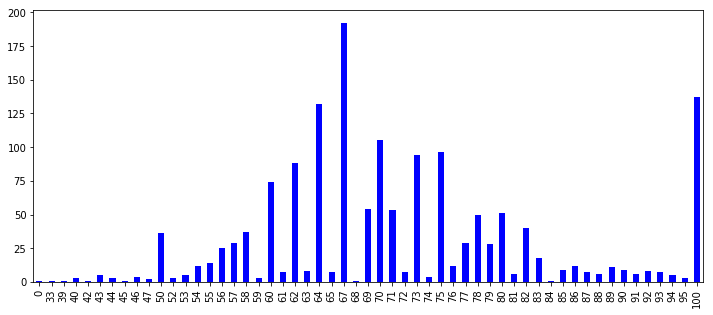

In [58]:
n_r = t_r.sort_values("highest_fuzzy_match_number", ascending=False)
n_r["highest_fuzzy_match_number"].value_counts(sort=False).plot(kind="bar", figsize=(12,5), colormap="winter")


In [59]:
display(n_r[n_r["highest_fuzzy_match_number"] == 100])

,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
795,arnerich newell,9,"ARNERICH, NEWELL",100,"ARNERICH, NEWELL KENNETH",262
515,gipson mike a,246,"GIPSON, MIKE A.",100,"GIPSON, MIKE",1483
182,keene richard,1,"KEENE, RICHARD",100,"KEENE, RICHARD J.",4234
866,antonovich michael d,1406,"ANTONOVICH, MICHAEL D.",100,"ANTONOVICH, MICHAEL",5
864,medina abigail m,631,"MEDINA, ABIGAIL M.",100,"MEDINA, ABIGAIL",1
194,petersonmore diana,4,"PETERSON-MORE, DIANA",100,"PETERSON-MORE, DIANA L.",1434
858,campbell john,144,"CAMPBELL, JOHN",100,"CAMPBELL, JOHN B.T.",2361
857,pacheco robert bob,876,"PACHECO, ROBERT \BOB\""""",100,"PACHECO, ROBERT",17
207,ong jennifer h,95,"ONG, JENNIFER H.",100,"ONG, JENNIFER",914
210,mullin gene r,619,"MULLIN, GENE R.",100,"MULLIN, GENE",994


In [60]:
d = n_r[n_r["highest_fuzzy_match_number"] > 90]
print(len(d))
display(d)

166


,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
795,arnerich newell,9,"ARNERICH, NEWELL",100,"ARNERICH, NEWELL KENNETH",262
515,gipson mike a,246,"GIPSON, MIKE A.",100,"GIPSON, MIKE",1483
182,keene richard,1,"KEENE, RICHARD",100,"KEENE, RICHARD J.",4234
866,antonovich michael d,1406,"ANTONOVICH, MICHAEL D.",100,"ANTONOVICH, MICHAEL",5
864,medina abigail m,631,"MEDINA, ABIGAIL M.",100,"MEDINA, ABIGAIL",1
194,petersonmore diana,4,"PETERSON-MORE, DIANA",100,"PETERSON-MORE, DIANA L.",1434
858,campbell john,144,"CAMPBELL, JOHN",100,"CAMPBELL, JOHN B.T.",2361
857,pacheco robert bob,876,"PACHECO, ROBERT \BOB\""""",100,"PACHECO, ROBERT",17
207,ong jennifer h,95,"ONG, JENNIFER H.",100,"ONG, JENNIFER",914
210,mullin gene r,619,"MULLIN, GENE R.",100,"MULLIN, GENE",994


In [61]:
display(n_r[(n_r["highest_fuzzy_match_number"] < 90) & (80 <= n_r["highest_fuzzy_match_number"])])

,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
171,fong paul,2124,"FONG, PAUL",89,"SONG, PAUL",9
992,tran john,65,"TRAN, JOHN",89,"EASTMAN, JOHN C.",1185
1111,silva james,346,"SILVA, JAMES",89,"LAU, JAMES",488
966,kelley david g,15,"KELLEY, DAVID G.",89,"KELLY, DAN",299
375,leyes mak,130,"LEYES, MAK",89,"LEYES, MARK A.",252
1084,silva jim,1040,"SILVA, JIM",89,"SILVA, JAMES",346
852,baker john,9,"BAKER, JOHN",89,"JAKE, JOHN",19
503,belden mark,4,"BELDEN, MARK",89,"LENO, MARK",7722
951,smith robert w,395,"SMITH, ROBERT W.",89,"SMITH, RON",14
587,costa jim,132,"COSTA, JIM",89,"COSTA, JAMES M.",1


In [62]:
t_r["highest_fuzzy_match_number"] = -1
t_r["highest_fuzzy_match_name"] = -1
t_r["highest_fuzzy_match_count"] = -1

size = len(t_r["clean_name"])

for i in range(size):
    name = t_r["clean_name"][i]
    r = []
    
    r += [[ 0, "self", 0]]
    
    for j in range(i + 1, size):
        test = t_r["clean_name"][j]
        fuz = fuzz.token_sort_ratio(name, test)
        r += [[ fuz, t_r["recipient_candidate_name"][j], t_r["count"][j] ]]
    
    #print(r)
    #break
    r.sort(reverse=True, key=lambda x: x[0])
    t_r.loc[i, "highest_fuzzy_match_number"] = r[0][0]
    t_r.loc[i, "highest_fuzzy_match_name"] = r[0][1]
    t_r.loc[i, "highest_fuzzy_match_count"] = r[0][2]


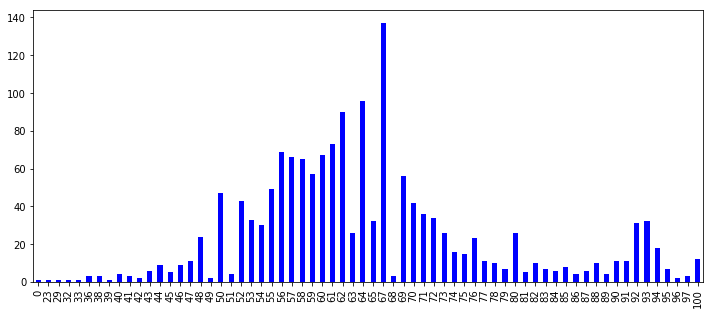

In [63]:
n_r = t_r.sort_values("highest_fuzzy_match_number", ascending=False)
n_r["highest_fuzzy_match_number"].value_counts(sort=False).plot(kind="bar", figsize=(12,5), colormap="winter")


In [64]:
d = n_r[n_r["highest_fuzzy_match_number"] > 90]
print(len(d))
display(d)

116


,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
418,vargas juan c,8,"VARGAS, JUAN C",100,"VARGAS, JUAN C.",2845
1099,jones judith e,40,"JONES, JUDITH E.",100,"JONES, JUDITH E",15
1115,olberg keith r,26,"OLBERG, KEITH R.",100,"OLBERG, R. KEITH",778
347,umberg tom,434,"UMBERG, TOM",100,"TOM, UMBERG",24
1171,jeffries kevin d,3,"JEFFRIES, KEVIN D",100,"JEFFRIES, KEVIN D.",1203
496,yee betty t,5048,"YEE , BETTY T.",100,"YEE, BETTY T.",351
309,michael wilson,4,"MICHAEL, WILSON",100,"WILSON, MICHAEL",39
1131,john j benoit,89,"JOHN J., BENOIT",100,"BENOIT, JOHN J.",2344
919,bonhach heather peters,192,"BONHACH, HEATHER PETERS",100,"PETERS BONHACH, HEATHER",33
756,pfeiler lori holt,300,"PFEILER, LORI HOLT",100,"HOLT PFEILER, LORI",63


In [65]:
display(n_r[(n_r["highest_fuzzy_match_number"] < 90) & (80 <= n_r["highest_fuzzy_match_number"])])

,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
251,hallinan jr tom,18,"HALLINAN JR., TOM",89,"HALLINAN, TOM",3
310,hallinan tom,3,"HALLINAN, TOM",89,"HALLINAN, THOMAS",383
465,monville iii louis g,321,"MONVILLE III, LOUIS G.",89,"MONVILLE III, LOU",10
816,kiraly virginia c,25,"KIRALY, VIRGINIA C.",89,"KIRALY, VIRGINIA CHANG",2
419,baca jr jr joe,2,"BACA JR. JR., JOE",88,"BACA. JR., JOE",12
933,gutierrez richard,5,"GUTIERREZ, RICHARD",88,"AGUIRRE, RICHARD",14
126,uranga tonia r,119,"URANGA, TONIA R.",88,"URANGA, TONIA REYES",490
1175,angelides phil,24652,"ANGELIDES, PHIL",88,"ANGELIDES, PHILIP N.",11
917,roesch jean,12,"ROESCH, JEAN",88,"ROESCH, JEAN DR.",58
968,negrete mcleod gloria,377,"NEGRETE MCLEOD, GLORIA",88,"MC LEOD, GLORIA NEGRETE",2914


In [66]:
t_r["highest_fuzzy_match_number"] = -1
t_r["highest_fuzzy_match_name"] = -1
t_r["highest_fuzzy_match_count"] = -1

size = len(t_r["clean_name"])

for i in range(size):
    name = t_r["clean_name"][i]
    r = []
    
    r += [[ 0, "self", 0]]
    
    for j in range(i + 1, size):
        test = t_r["clean_name"][j]
        fuz = fuzz.token_set_ratio(name, test)
        r += [[ fuz, t_r["recipient_candidate_name"][j], t_r["count"][j] ]]
    
    #print(r)
    #break
    r.sort(reverse=True, key=lambda x: x[0])
    t_r.loc[i, "highest_fuzzy_match_number"] = r[0][0]
    t_r.loc[i, "highest_fuzzy_match_name"] = r[0][1]
    t_r.loc[i, "highest_fuzzy_match_count"] = r[0][2]


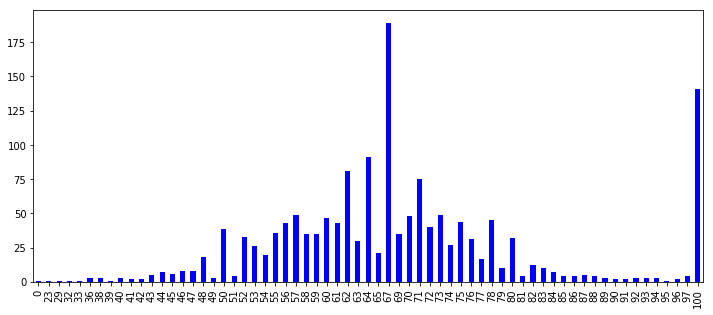

In [67]:
n_r = t_r.sort_values("highest_fuzzy_match_number", ascending=False)
n_r["highest_fuzzy_match_number"].value_counts(sort=False).plot(kind="bar", figsize=(12,5), colormap="winter")


In [68]:
d = n_r[n_r["highest_fuzzy_match_number"] > 90]
print(len(d))
display(d)

159


,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
386,schaupp charles e,149,"SCHAUPP, CHARLES E.",100,"SCHAUPP, CHARLES",4
1091,wyman phillip,76,"WYMAN, PHILLIP",100,"WYMAN, PHILLIP D.",945
124,brown willie l,683,"BROWN, WILLIE L.",100,"BROWN JR., WILLIE L.",284
251,hallinan jr tom,18,"HALLINAN JR., TOM",100,"HALLINAN, TOM",3
383,gaines beth,111,"GAINES, BETH",100,"GAINES, BETH B.",1214
129,furutani warren,4781,"FURUTANI, WARREN",100,"FURUTANI, WARREN T.",3
381,medina jose,59,"MEDINA, JOSE",100,"MEDINA, JOSE J.",1740
756,pfeiler lori holt,300,"PFEILER, LORI HOLT",100,"HOLT PFEILER, LORI",63
1099,jones judith e,40,"JONES, JUDITH E.",100,"JONES, JUDITH E",15
1098,hunter tricia rae,421,"HUNTER, TRICIA RAE",100,"HUNTER, TRICIA",2


In [69]:
display(n_r[(n_r["highest_fuzzy_match_number"] < 90) & (80 <= n_r["highest_fuzzy_match_number"])])

,clean_name,count,recipient_candidate_name,highest_fuzzy_match_number,highest_fuzzy_match_name,highest_fuzzy_match_count
310,hallinan tom,3,"HALLINAN, TOM",89,"HALLINAN, THOMAS",383
465,monville iii louis g,321,"MONVILLE III, LOUIS G.",89,"MONVILLE III, LOU",10
171,fong paul,2124,"FONG, PAUL",89,"SONG, PAUL",9
968,negrete mcleod gloria,377,"NEGRETE MCLEOD, GLORIA",88,"MC LEOD, GLORIA NEGRETE",2914
933,gutierrez richard,5,"GUTIERREZ, RICHARD",88,"AGUIRRE, RICHARD",14
1175,angelides phil,24652,"ANGELIDES, PHIL",88,"ANGELIDES, PHILIP N.",11
70,harrison michael,315,"HARRISON, MICHAEL",88,"HARRINGTON, MICHAEL",3
333,medford james d,2,"MEDFORD, JAMES D.",87,"LEDFORD, JAMES C.",239
37,akili gregory,118,"AKILI, GREGORY",87,"AKILI, GREG",4
774,eng michael,4478,"ENG, MICHAEL",87,"FONG, MICHAEL",1820


In [80]:
# people with like JR or II, CHAVEZ, CHRISTINA vs CHAVEZ, CHRISTINE, DIEP, TYLER vs IZEN, TYLER, MANN, CHRIS vs LEHMAN, CHRIS
# IF only there was a way to weight last names higher, but there are some people who's names look entered in reverse
# take a look at all names with a , in them
sum(n_r["recipient_candidate_name"].str.contains(","))/len(n_r)


1.0

In [ ]:
display(n_r[n_r[highest_fuzzy_match_count] == 0])